In [4]:
import numpy as np 
import torch

import datasets.mnist as mnist
import datasets.cifar10 as cifar10
import constants
import metrics
from configuration import Configuration

from util import *

In [33]:
# on the cblgpu08 computer

# different methods
checkpoints = [('run-20210514_191847-3u588wxi', 'NC Ens 3, reg 0.5'), ('run-20210514_192309-2rlfhitc', 'Ens 3'),
('run-20210514_192736-3q5el7rl', 'MC drop 3, rate 0.5'), ('run-20210514_193101-nyehd80r', 'Single')]

# different NC weight
# checkpoints = [('run-20210514_191847-3u588wxi', 'NCEns 3, reg 0.5'), ('run-20210514_223116-3tusc1ni', 'NCEns 3, reg 0.1'),
# ('run-20210514_223603-1ogek1sb', 'NCEns 3, reg 0.3'), ('run-20210514_224048-14iqxlw4', 'NCEns 3, reg 0.7'),
# ('run-20210514_224531-375asb5u', 'NCEns 3, reg 1'), ('run-20210514_225017-aiy9lfbx', 'NCEns 3, reg 2')] 

In [34]:
corruption_intensity = 60
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100)

res = []

for run_id, name in checkpoints:

    checkpointed_args = f'/scratch/gp491/wandb/checkpoints/{run_id}/args.json'
    checkpointed_model = f'/scratch/gp491/wandb/checkpoints/{run_id}/epoch_20.pth'

    model_args = Configuration.from_json(checkpointed_args)
    trainer = get_trainer(model_args, device='cpu')
    trainer.load_checkpoint(checkpointed_model)

    test_loader = mnist.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, intensity=corruption_intensity, corruption='rotation')


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)

    res.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

  0%|          | 0/79 [00:00<?, ?batch/s]Initialising a negative-correlation normalised ensemble of 3 networks

Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/metrics.py:200: UserWarning: Warning: converting a masked element to nan.
  accuracies[i] = np.ma.masked_array(eq, mask=~mask).mean(-1)
  0%|          | 0/79 [00:00<?, ?batch/s]Results: 
Accuracy: 0.2309
NLL: 3.4054009433746337
ECE: 0.477344659820199
Brier: 1.1473865507125856
Initialising a negative-correlation norma

In [35]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Accuracy vs Confidence. Rotation, intensity 60')

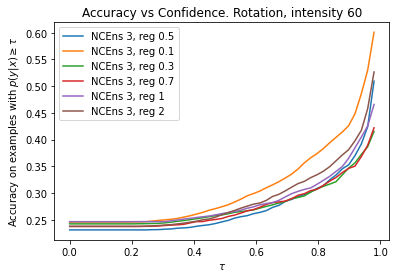

In [36]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_accuracies, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. Rotation, intensity {corruption_intensity}')

Text(0.5, 1.0, 'Count vs Confidence. Rotation, intensity 60')

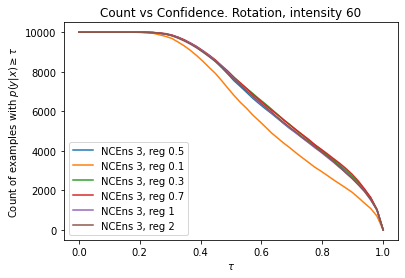

In [37]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. Rotation, intensity {corruption_intensity}')

Text(0.5, 1.0, 'Count vs Entropy. Rotation, intensity 60')

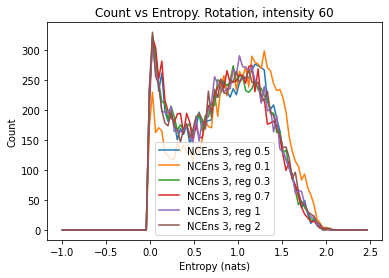

In [38]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. Rotation, intensity {corruption_intensity}')